## Interpretation of TF models trained on UniRef90 dataset for multiclass classification

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/..']

In [2]:
from prediction.models.nlp import transformer
from src.utils import utils, nn_utils

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE



In [3]:
input_dir = "/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635"
train_file_names = ["uniref90_final.csv_tr0.8_train.csv"]
test_file_names = ["uniref90_final.csv_tr0.8_test.csv"]
classification_type = "multi"

label_groupings = {"Human": [ "Homo sapiens" ],
                  "Desert warthog": [ "Phacochoerus aethiopicus" ],
                  "Lesser bandicoot rat": [ "Bandicota bengalensis" ],
                  "Horse": [ "Equus caballus" ],
                  "Goat": [ "Capra hircus" ],
                  "Red junglefowl": [ "Gallus gallus" ],
                  "Wood mouse": [ "Apodemus sylvaticus" ],
                  "Cattle": [ "Bos taurus" ],
                  "Others": [ "*" ]}
host_classes = ["Homo sapiens",  "Phacochoerus aethiopicus",    "Bandicota bengalensis",     "Equus caballus",   "Capra hircus", 
                "Gallus gallus",   "Apodemus sylvaticus",     "Bos taurus",  "Others"]

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1115,
    "pad_sequence_val": 0,
    "truncate": True
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

label_col = label_settings["label_col"]

model = {
    "max_seq_len": 1115,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 9,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

### Load the datasets

In [4]:
# def load_dataset(input_dir, input_file_names, sequence_settings):
#     df = utils.read_dataset(input_dir, input_file_names, cols=[sequence_settings["sequence_col"], label_settings["label_col"]])
#     df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
#     dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
#     return index_label_map, dataset_loader

# def load_dataset_with_df(df, sequence_settings):
#     df = df[[sequence_settings["sequence_col"], label_settings["label_col"]]]
#     df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
#     dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
#     return index_label_map, dataset_loader

# def print_dataset_loader(dataset_loader):
#     sequence, label = next(iter(dataset_loader))
#     print(sequence.shape)
#     print(sequence)
#     print(label.shape)
#     print(label)

### Training-based interpretation
#### Encoding visualization - all viruses, all hosts

In [5]:
def compute_dataset_representations(nlp_model, dataset_loader):
    nlp_model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = nlp_model(seq)
        seq_encoding = nlp_model.encoder.encoding
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df


def visualize_dataset(rep_df):
    columns = rep_df.columns
    print(columns)
    X = rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_emb.shape)
    print(X_emb)
    X_emb["label"] = rep_df["label"].values
    return tsne_model, X_emb
    
def visualize_prediction(nlp_model, seq, label, rep_df):
    nlp_model.eval()
    output = nlp_model(seq)
    seq_encoding = nlp_model.encoder.encoding
    seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)

    seq_df = pd.DataFrame(seq_encoding.squeeze(1).cpu().detach().numpy())
    seq_df["label"] = label.squeeze().cpu().detach().numpy()
    sample_pred = torch.argmax(F.softmax(output, dim=1), dim=1)
    print(f"Label {label} = {index_label_map[label.item()]}")
    sample_pred_mapped = index_label_map[sample_pred.item()]
    print(f"Prediction {sample_pred}= {sample_pred_mapped}")
    seq_df["label"] = "prediction-" + sample_pred_mapped
    
    rep_df_copy = rep_df.copy()
    rep_df_copy["label"] = rep_df["label"].map(index_label_map)
    rep_df_copy = rep_df_copy[rep_df_copy["label"] != "Others"]
    X = rep_df_copy[range(512)]
    print(f"X shape = {X.shape}")
    
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(f"X_emb shape = {X_emb.shape}")
    X_emb["label"] = rep_df_copy["label"].values
    print(f"X_emb shape = {X_emb.shape}")
    sns.scatterplot(data = X_emb, x=0, y=1, hue="label")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    figure_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/visualization/uniref90/20230713/host_multi_ismb/tf-prot-seq-embedding-pca-tsne.svg")
    plt.savefig(figure_output_filepath, format="svg")
    plt.show()

### Testing-based interpretation
#### Attention based interpretation

In [6]:
def compute_mean_attn_values(nlp_model):
    attn_values = nlp_model.encoder.layers[5].self_attn.self_attn.squeeze()
    return torch.mean(attn_values, dim=0)


def plot_mean_attention_values(x, seq=None, seq_len=None):
    ticklabels = seq.cpu().detach().numpy().squeeze()[:seq_len]
    ticklabels_mapped = [idx_amino_acid_map[x] for x in ticklabels]

    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 5
    plt.figure(figsize=(12,12))
    data = x.cpu().detach().numpy()
    
    sns.heatmap(data=data[:seq_len, :seq_len], xticklabels=ticklabels_mapped, yticklabels=ticklabels_mapped)
    #plt.xticks(rotation=20)
    plt.show()


def plot_mean_of_mean_attention_values(x, seq=None, seq_len=None, seq_max_length=None):
    tokens = seq.cpu().detach().numpy().squeeze()
    
    x = torch.mean(x, dim=0)
    df = pd.DataFrame({"tokens": tokens, "attn_vals": x.cpu().detach().numpy(), "pos": range(seq_max_length)})
    df["tokens"] = df["tokens"].map(idx_amino_acid_map)
    df = df.dropna()
    sorted_df = df.sort_values(by="attn_vals", ascending=False).head(10)
    print("Top 10 tokens + positions with highest attention values for the whole sequence")
    print(sorted_df.head(10))
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=df, x="pos", y="attn_vals", hue="tokens")
    plt.show()
    
def analyze_attention_of_prediction(nlp_model, sample_seq, sample_label, seq_max_length):
    # sample_seq = sample_seq.unsqueeze(0)
    seq_len= torch.count_nonzero(sample_seq)
    print(sample_seq.shape)
    print(f"seq_len = {seq_len}")
    
    nlp_model.eval()
    output = nlp_model(sample_seq)
    sample_pred = torch.argmax(F.softmax(nlp_model(sample_seq), dim=1), dim=1)
    print(f"Label = {index_label_map[sample_label.item()]}")
    print(f"Prediction = {index_label_map[sample_pred.item()]}")
    mean_attn_values = compute_mean_attn_values(nlp_model)

    plot_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len)
    plot_mean_of_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len, seq_max_length=seq_max_length)
    
def analyze_attention_of_df(nlp_model, dataset_loader, seq_max_length):
    attn_dfs = []
    max_seq_len_actual = 0
    for _, record in enumerate(dataset_loader):
        seq, label = record
        seq_len = torch.count_nonzero(seq).item()
#         if seq_len > max_seq_len_actual:
#             max_seq_len_actual = seq_len
        if seq_len < seq_max_length:
            continue
        nlp_model(seq)
        mean_attn_values = compute_mean_attn_values(nlp_model)
        mean_of_mean = torch.mean(mean_attn_values, dim=0, keepdim=True)
        attn_dfs.append(mean_of_mean.cpu().detach().numpy())
    print("max_seq_len_actual = ", max_seq_len_actual)
    attn_df = np.concatenate(attn_dfs, axis=0)
    plt.figure(figsize=(12,12))
    sns.heatmap(data=attn_df)#[:,:max_seq_len_actual])
    return attn_df

In [7]:
def get_top_10_attn_vals_df(nlp_model, dataset_loader, seq_max_length):
    seq_i = 0
    top_10_attn_vals = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        label = index_label_map[label.item()]
        
        seq_len = torch.count_nonzero(seq).item()
        pred = torch.argmax(F.softmax(nlp_model(seq), dim=1), dim=1)
        pred = index_label_map[pred.item()]
        
        mean_attn_values = compute_mean_attn_values(nlp_model)
        mean_of_mean = torch.mean(mean_attn_values, dim=0)
        
        tokens = seq.cpu().detach().numpy().squeeze()
        seq_attn_df = pd.DataFrame({"tokens": tokens,
                                    "attn_vals": mean_of_mean.cpu().detach().numpy(),
                                    "pos": range(seq_max_length)})
        seq_attn_df["tokens"] = seq_attn_df["tokens"].map(idx_amino_acid_map)
        seq_attn_df = seq_attn_df.dropna()
        seq_attn_df = seq_attn_df.sort_values(by="attn_vals", ascending=False).head(10)
        seq_attn_df["seq_number"] = seq_i
        seq_attn_df["label"] = label
        seq_attn_df["pred"] = pred
        
        top_10_attn_vals.append(seq_attn_df)
        
        seq_i += 1 
    top_10_attn_vals_df = pd.concat(top_10_attn_vals)
    return top_10_attn_vals_df
        

def get_attention_of_df(nlp_model, dataset_loader, seq_max_length):
    attn_dfs = []
    max_seq_len_actual = 0
    for _, record in enumerate(dataset_loader):
        seq, label = record
        seq_len = torch.count_nonzero(seq).item()
#         if seq_len > max_seq_len_actual:
#             max_seq_len_actual = seq_len
        if seq_len < seq_max_length:
            continue
        label = index_label_map[label.item()]
        pred = torch.argmax(F.softmax(nlp_model(seq), dim=1), dim=1)
        pred = index_label_map[pred.item()]
        mean_attn_values = compute_mean_attn_values(nlp_model)
        mean_of_mean = torch.mean(mean_attn_values, dim=0, keepdim=True)
        df = pd.DataFrame(mean_of_mean.cpu().detach().numpy(), columns=range(seq_max_length))
        df["label"] = label
        df["pred"] = pred
        attn_dfs.append(df)
    
    attn_df = pd.concat(attn_dfs, axis=0)

    return attn_df

 ### Analysis Pipeline

In [9]:
def analyse_model(model, train_dataset_loader, test_dataset_loader, seq, label, seq_max_length, viz_train=False, viz_test=False):
    if viz_train:
        train_rep_df = compute_dataset_representations(model, train_dataset_loader)
        visualize_prediction(model, seq, label, train_rep_df)
    if viz_test:
        test_rep_df = compute_dataset_representations(model, test_dataset_loader)
        visualize_dataset(test_rep_df)
    
    
    analyze_attention_of_prediction(model, seq, label, seq_max_length)
    
    analyze_attention_of_df(model, test_dataset_loader, seq_max_length)

#### UniRef90 Datasets
19k
all viruses, all hosts, all proteins, without duplicates and single hosts

In [10]:
index_label_map, train_dataset_loader = load_dataset(input_dir, train_file_names, 
                                                     train_sequence_settings,
                                                     [train_sequence_settings["sequence_col"], label_col],
                                                     label_settings,
                                                     label_col)

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_train.csv, size = (15274, 2)
Size of input dataset = (15274, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4 3 0 6 5 1 2 8 7]
torch.Size([8, 1115])
tensor([[13, 17, 19,  ...,  0,  0,  0],
        [13,  4, 10,  ...,  0,  0,  0],
        [13,  6, 11,  ...,  0,  0,  0],
  

In [11]:
index_label_map, test_dataset_loader = load_dataset(input_dir, test_file_names, test_sequence_settings)
# Random seq, label from test_dataset_loader
test_seq, test_label = next(iter(test_dataset_loader))

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_test.csv, size = (3819, 2)
Size of input dataset = (3819, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4 5 3 1 7 8 6 0 2]
torch.Size([1, 1115])
tensor([[13, 11, 11,  ...,  0,  0,  0]], device='cuda:0')
torch.Size([1])
tensor([1], device='cuda:0')


#### UniProtKB Coronavirus only

In [12]:
uniref90_coronaviruses_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/coronaviridae_top_7_hosts.csv")
uniref90_coronaviruses_df.head()

id                                                seq  \
0  A3EX94  MTLLMCLLMSLLIFVRGCDSQFVDMSPASNTSECLESQVDAAAFSK...   
1  A3EXD0  MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFES...   
2  P0DTC2  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
3  P11223  MLVTPLLLVTLLCALCSAVLYDSSSYVYYYQSAFRPPSGWHLQGGA...   
4  P12651  MLVTPLLLVTLLCVLCSAALYDSSSYVYYYQSAFRPPNGWHLHGGA...   

                                               virus  seq_len  \
0     Bat coronavirus HKU4 (BtCoV) (BtCoV/HKU4/2004)     1352   
1     Bat coronavirus HKU5 (BtCoV) (BtCoV/HKU5/2004)     1352   
2  Severe acute respiratory syndrome coronavirus ...     1273   
3  Avian infectious bronchitis virus (strain Beau...     1162   
4  Avian infectious bronchitis virus (strain M41)...     1162   

                                          virus_host binary_label  
0  Tylonycteris pachypus (Lesser bamboo bat) (Ves...    Not Human  
1  Pipistrellus abramus (Japanese pipistrelle) (P...    Not Human  
2                 Homo sapiens (Human) [TaxID: 9606]        Human  
3              Gallus gallus (Chicken) [TaxID: 9031]    Not Human  
4              Gallus gallus (Chicken) [TaxID: 9031]    Not Human

In [13]:
uniref90_coronaviruses_df["virus_host"].value_counts()

Sus scrofa (Pig) [TaxID: 9823]                                                                  2620
Homo sapiens (Human) [TaxID: 9606]                                                              2400
Meleagris gallopavo (Wild turkey) [TaxID: 9103]                                                   36
Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]      19
Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]                  17
Gallus gallus (Chicken) [TaxID: 9031]                                                             13
Bos taurus (Bovine) [TaxID: 9913]                                                                 10
Name: virus_host, dtype: int64

In [14]:
uniref90_coronaviruses_humans_df = uniref90_coronaviruses_df[uniref90_coronaviruses_df["virus_host"] == "Homo sapiens (Human) [TaxID: 9606]"]
print(uniref90_coronaviruses_humans_df.shape)
uniref90_coronaviruses_humans_df.head()

(2400, 6)


id                                                seq  \
2   P0DTC2  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
5   P15423  MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...   
12  P36334  MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...   
14  Q0ZME7  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   
15  Q14EB0  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   

                                                virus  seq_len  \
2   Severe acute respiratory syndrome coronavirus ...     1273   
5                  Human coronavirus 229E (HCoV-229E)     1173   
12                 Human coronavirus OC43 (HCoV-OC43)     1353   
14    Human coronavirus HKU1 (isolate N5) (HCoV-HKU1)     1351   
15    Human coronavirus HKU1 (isolate N2) (HCoV-HKU1)     1351   

                            virus_host binary_label  
2   Homo sapiens (Human) [TaxID: 9606]        Human  
5   Homo sapiens (Human) [TaxID: 9606]        Human  
12  Homo sapiens (Human) [TaxID: 9606]        Human  
14  Homo sapiens (Human) [TaxID: 9606]        Human  
15  Homo sapiens (Human) [TaxID: 9606]        Human

In [15]:
uniref90_coronaviruses_humans_df["virus_host"] = "Homo sapiens"
uniref90_coronaviruses_humans_df.rename(columns={"virus_host": "virus_host_name"}, inplace=True)
uniref90_coronaviruses_humans_df.head()

/tmp/ipykernel_16496/804901245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniref90_coronaviruses_humans_df["virus_host"] = "Homo sapiens"
/tmp/ipykernel_16496/804901245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniref90_coronaviruses_humans_df.rename(columns={"virus_host": "virus_host_name"}, inplace=True)


id                                                seq  \
2   P0DTC2  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
5   P15423  MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...   
12  P36334  MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...   
14  Q0ZME7  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   
15  Q14EB0  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   

                                                virus  seq_len  \
2   Severe acute respiratory syndrome coronavirus ...     1273   
5                  Human coronavirus 229E (HCoV-229E)     1173   
12                 Human coronavirus OC43 (HCoV-OC43)     1353   
14    Human coronavirus HKU1 (isolate N5) (HCoV-HKU1)     1351   
15    Human coronavirus HKU1 (isolate N2) (HCoV-HKU1)     1351   

   virus_host_name binary_label  
2     Homo sapiens        Human  
5     Homo sapiens        Human  
12    Homo sapiens        Human  
14    Homo sapiens        Human  
15    Homo sapiens        Human

min seq len = 35
max seq len = 1366


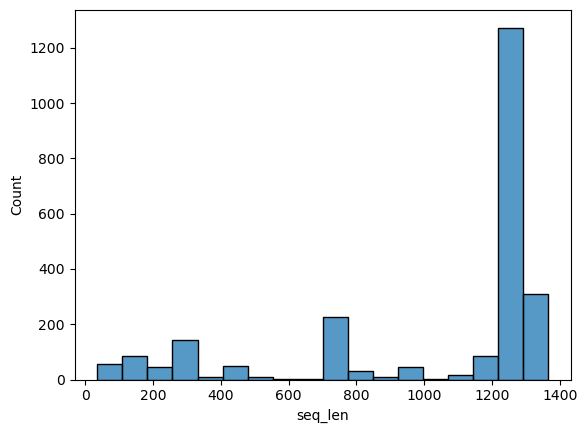

In [16]:
sns.histplot(uniref90_coronaviruses_humans_df["seq_len"])
print(f"min seq len = {min(uniref90_coronaviruses_humans_df['seq_len'])}")
print(f"max seq len = {max(uniref90_coronaviruses_humans_df['seq_len'])}")
plt.show()

In [17]:
_, coronavirus_dataset_loader = load_dataset_with_df(uniref90_coronaviruses_humans_df, test_sequence_settings)
# Random seq, label from coronavirus_dataset_loader
coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))

Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4]
torch.Size([1, 1115])
tensor([[13, 14, 22,  ...,  6, 10, 10]], device='cuda:0')
torch.Size([1])
tensor([4], device='cuda:0')


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

#### WIV04 Wuhan Index Virus S protein

In [18]:
wiv04_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/sarscov2-S-WIV04ref.csv")
wiv04_df.rename(columns={"virus_host": "virus_host_name"}, inplace=True)
wiv04_df["virus_host_name"] = "Homo sapiens"
wiv04_df.head()

id                                                seq  \
0  WIV04  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   

                                         virus  seq_len virus_host_name  \
0  WIV04(MN996528.1) Wuhan variant index virus     1273    Homo sapiens   

  binary_label  
0        Human

In [19]:
_, wiv04_dataset_loader = load_dataset_with_df(wiv04_df, test_sequence_settings)
wiv04_seq, wiv04_label = next(iter(wiv04_dataset_loader))

Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4]
torch.Size([1, 1115])
tensor([[13, 14, 22,  ...,  6, 10, 10]], device='cuda:0')
torch.Size([1])
tensor([4], device='cuda:0')
tensor([[13, 14, 22,  ...,  6, 10, 10]], device='cuda:0')
tensor([4], device='cuda:0')


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

### Load the trained model

#### Model: TF - PosEmb_SINCOS - MSL_1024 - d_512
#### Manual Seed = 0

In [20]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230705/host_multi_msl1114_baseline/transformer_itr0.pth"

nlp_model = transformer.get_transformer_model(model)
nlp_model.load_state_dict(torch.load(model_path))
nlp_model = nlp_model.to(nn_utils.get_device())


Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=9, b

##### UniRef90

(15274, 513)
Label tensor([4], device='cuda:0') = Human
Prediction tensor([4], device='cuda:0')= Human
X shape = (14662, 512)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14662 samples in 0.062s...
[t-SNE] Computed neighbors for 14662 samples in 8.346s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14662
[t-SNE] Computed conditional probabilities for sample 2000 / 14662
[t-SNE] Computed conditional probabilities for sample 3000 / 14662
[t-SNE] Computed conditional probabilities for sample 4000 / 14662
[t-SNE] Computed conditional probabilities for sample 5000 / 14662
[t-SNE] Computed conditional probabilities for sample 6000 / 14662
[t-SNE] Computed conditional probabilities for sample 7000 / 14662
[t-SNE] Computed conditional probabilities for sample 8000 / 14662
[t-SNE] Computed conditional probabilities for sample 9000 / 14662
[t-SNE] Computed conditional probabilities for sample 10000 / 14662
[t-SNE] Computed conditional probabilities for sample 11000 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.279190
[t-SNE] KL divergence after 1000 iterations: 1.010712
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14662 samples in 0.028s...
[t-SNE] Computed neighbors for 14662 samples in 7.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14662
[t-SNE] Computed conditional probabilities for sample 2000 / 14662
[t-SNE] Computed conditional probabilities for sample 3000 / 14662
[t-SNE] Computed conditional probabilities for sample 4000 / 14662
[t-SNE] Computed conditional probabilities for sample 5000 / 14662
[t-SNE] Computed conditional probabilities for sample 6000 / 14662
[t-SNE] Computed conditional probabilities for sample 7000 / 14662
[t-SNE] Computed conditional probabilities for sample 8000 / 14662
[t-SNE] Computed conditional probabilities for sample 9000 / 14662
[t-SNE] Computed conditional probabilities for sample 10000 / 14662
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.276596
[t-SNE] KL divergence after 1000 iterations: 1.010190
X_emb shape = (14662, 2)
X_emb shape = (14662, 3)


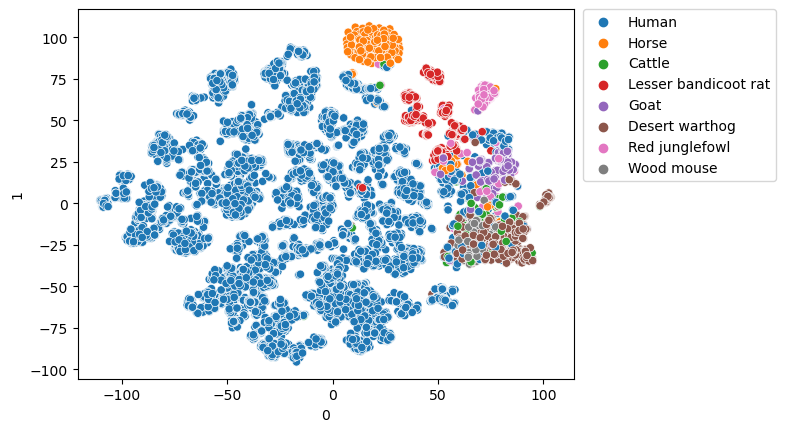

torch.Size([1, 1115])
seq_len = 166
Label = Human
Prediction = Human


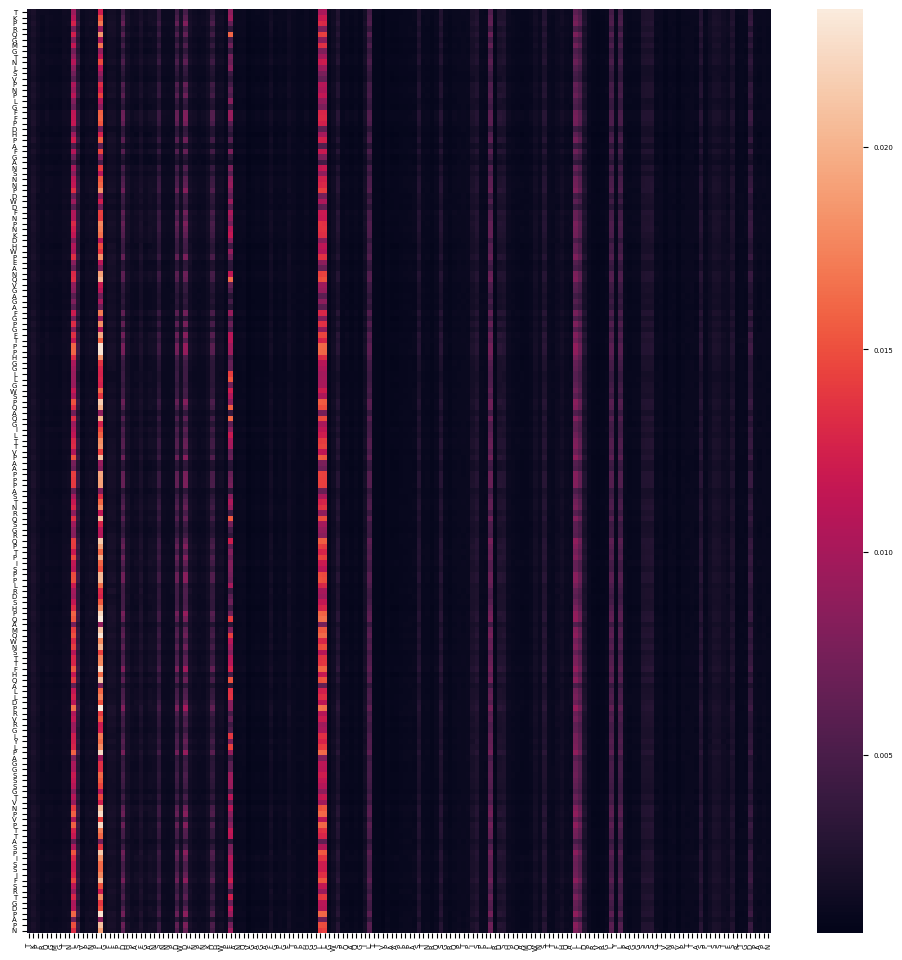

Top 10 tokens + positions with highest attention values for the whole sequence
    tokens  attn_vals  pos
16       L   0.030094   16
65       L   0.019917   65
66       L   0.019801   66
10       L   0.019512   10
45       E   0.017908   45
35       D   0.009959   35
122      L   0.009840  122
103      L   0.008050  103
21       D   0.007907   21
123      L   0.007606  123


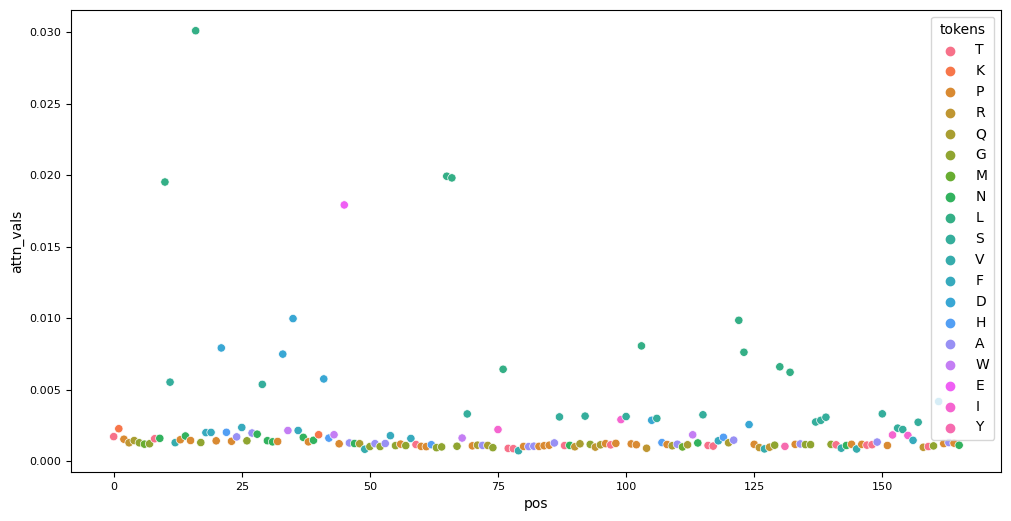

max_seq_len_actual =  0


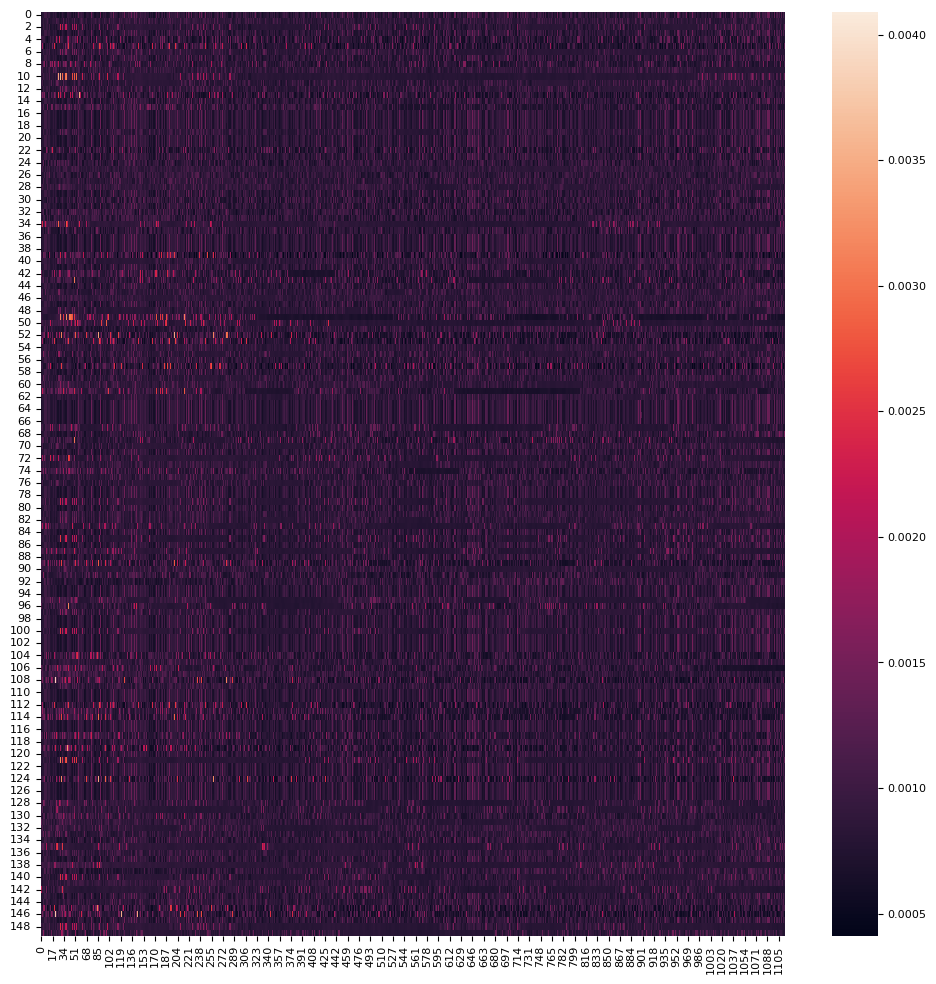

In [20]:
analyse_model(nlp_model, train_dataset_loader, test_dataset_loader, test_seq, test_label, seq_max_length=1115, viz_train=True, viz_test=False)

##### WIV04 Wuhan Index Virus S protein

torch.Size([1, 1115])
seq_len = 1115
Label = Human
Prediction = Red junglefowl


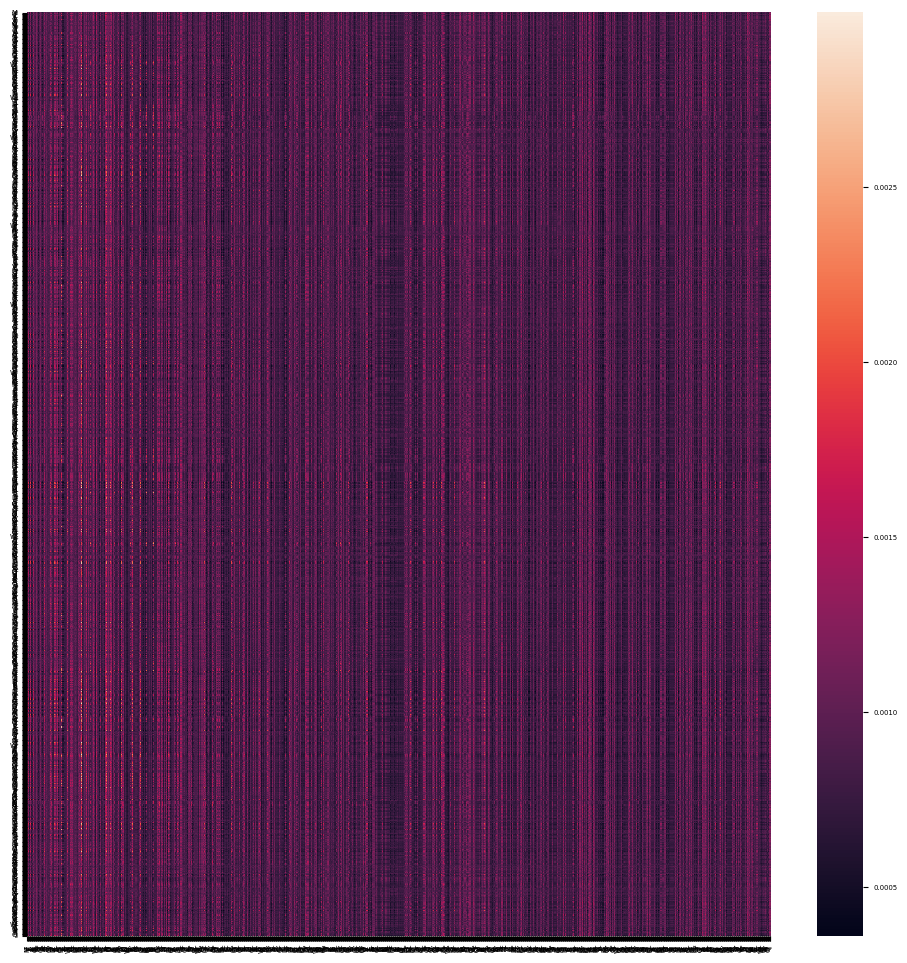

Top 10 tokens + positions with highest attention values for the whole sequence
    tokens  attn_vals  pos
82       V   0.001641   82
119      V   0.001502  119
192      V   0.001491  192
48       H   0.001429   48
158      V   0.001415  158
142      V   0.001356  142
89       V   0.001351   89
118      I   0.001347  118
170      V   0.001346  170
126      V   0.001340  126


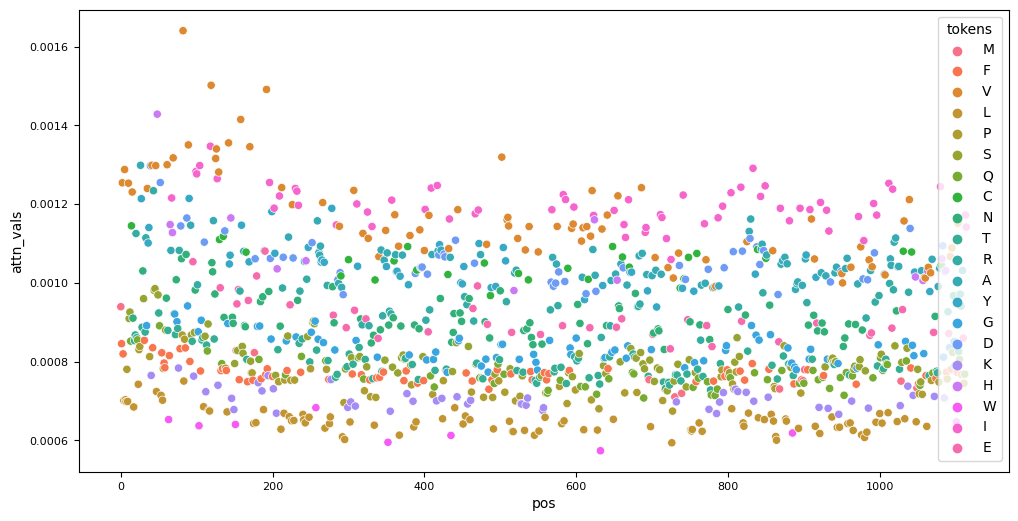

max_seq_len_actual =  0


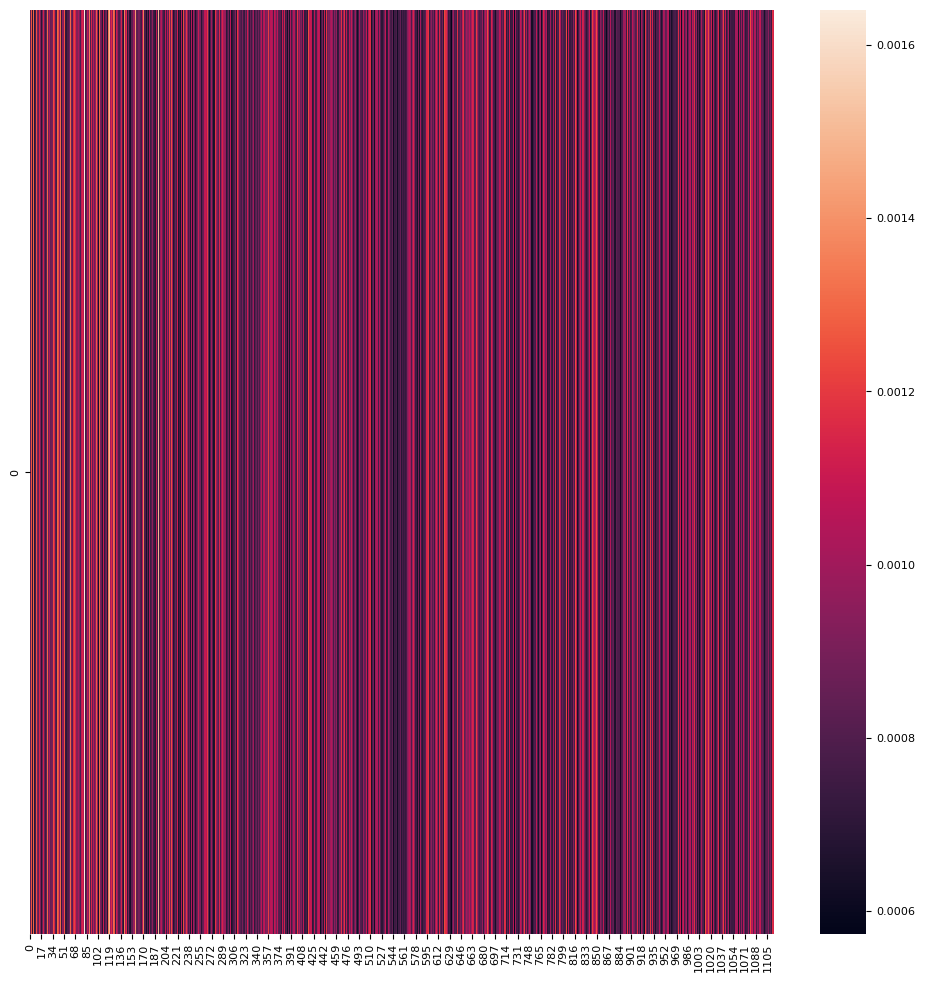

In [20]:
analyse_model(nlp_model, train_dataset_loader, wiv04_dataset_loader, wiv04_seq, wiv04_label, seq_max_length=1115, viz_train=False, viz_test=False)

**Saliency Maps - WIP**

In [18]:
wiv04_seq = wiv04_seq.float()
wiv04_seq.requires_grad=True
nlp_model.eval()
output = nlp_model(wiv04_seq)
sample_pred = torch.argmax(F.softmax(nlp_model(wiv04_seq), dim=1), dim=1)
print(f"Label = {index_label_map[wiv04_label.item()]}")
print(f"Prediction = {index_label_map[sample_pred.item()]}")
loss_ce = nn.CrossEntropyLoss(reduction="none")(output, wiv04_label.flatten())


grad = torch.autograd.grad(loss_ce, wiv04_seq, grad_outputs=torch.ones_like(loss_ce), allow_unused=True)
print(grad)

Label = Human
Prediction = Red junglefowl
(None,)


##### Coronaviridae S protein dataset

In [21]:
rbd_positions = [332,333,334,335,337,339,340,344,345,346,347,348,349,351,352,354,356,359,362,364,366,367,370,371,372,373,375,376,378,380,381,382,384,385,388,389,390,393,394,395,396,397,399,401,402,403,404,405,406,407,410,411,412,413,414,415,417,418,419,420,424,425,426,427,428,430,431,432,433,434,435,436,437,438,439,440,441,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,489,490,491,493,494,495,496,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524]
rbm_positions = range(438, 506)

In [22]:
def analyze_top_10_attn_vals_df(nlp_model, coronavirus_dataset_loader, seq_max_length=1115):
    top_10_attn_vals_df = get_top_10_attn_vals_df(nlp_model, coronavirus_dataset_loader, seq_max_length=1115)
    # increment the positions number by 1 since in the df it is 0-indexed
    top_10_attn_vals_df["pos"] = top_10_attn_vals_df["pos"] + 1
    print(f"top_10_attn_vals_df size = {top_10_attn_vals_df.shape}")
    
    # get the true predictions
    true_pred_coronavirus_df = top_10_attn_vals_df[top_10_attn_vals_df["label"] == top_10_attn_vals_df["pred"]]
    print(f"true_pred_coronavirus_df size = {true_pred_coronavirus_df.shape}")
    
    print(f"True prediction accuracy = {true_pred_coronavirus_df.shape[0]/top_10_attn_vals_df.shape[0] * 100}")
    
    # add a column to mark whether the position falls in the rbd domain, rbm domain
    true_pred_coronavirus_df["rbd_domain"] = true_pred_coronavirus_df["pos"].isin(rbd_positions)
    true_pred_coronavirus_df["rbm_domain"] = true_pred_coronavirus_df["pos"].isin(rbm_positions)
    
    # get number of rbd positions in each sequence
    rbd_count = true_pred_coronavirus_df[["seq_number", "pos", "rbd_domain"]].groupby(["seq_number", "rbd_domain"]).count()
    rbd_count = rbd_count.reset_index()
    print(f"Number of sequences with RBDs = {rbd_count[rbd_count['rbd_domain'] == True]['seq_number'].nunique()}")
    print(f"Average number of RBDs in sequences = {rbd_count[rbd_count['rbd_domain'] == True]['pos'].mean()}")

    # get number of rbm positions in each sequence
    rbm_count = true_pred_coronavirus_df[["seq_number", "pos", "rbm_domain"]].groupby(["seq_number", "rbm_domain"]).count()
    rbm_count = rbm_count.reset_index()
    print(f"Number of sequences with RBMs = {rbm_count[rbm_count['rbm_domain'] == True]['seq_number'].nunique()}")
    print(f"Average number of RBMs in sequences = {rbm_count[rbm_count['rbm_domain'] == True]['pos'].mean()}")

In [23]:
analyze_top_10_attn_vals_df(nlp_model, coronavirus_dataset_loader, seq_max_length=1115)

top_10_attn_vals_df size = (24000, 6)
true_pred_coronavirus_df size = (6830, 6)
True prediction accuracy = 28.458333333333336
Number of sequences with RBDs = 585
Average number of RBDs in sequences = 2.5213675213675213
Number of sequences with RBMs = 572
Average number of RBMs in sequences = 2.3846153846153846


/tmp/ipykernel_16496/1811217297.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_pred_coronavirus_df["rbd_domain"] = true_pred_coronavirus_df["pos"].isin(rbd_positions)
/tmp/ipykernel_16496/1811217297.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_pred_coronavirus_df["rbm_domain"] = true_pred_coronavirus_df["pos"].isin(rbm_positions)


In [111]:
attn_df = get_attention_of_df(nlp_model, coronavirus_dataset_loader, seq_max_length=1115)

In [112]:
true_pred_attn_df = attn_df[attn_df["pred"] == attn_df["label"]]

In [113]:
true_pred_attn_df = true_pred_attn_df.reset_index(drop=True)

In [114]:
true_pred_attn_df.shape

(616, 1117)

In [115]:
true_pred_attn_df = true_pred_attn_df.drop(columns=["label", "pred"])

In [116]:
true_pred_attn_df.shape

(616, 1115)

In [117]:
true_pred_attn_df

0         1         2         3         4         5         6     \
0    0.000945  0.000846  0.001001  0.000821  0.001212  0.000971  0.001176   
1    0.000941  0.000860  0.000928  0.000836  0.001405  0.000896  0.001350   
2    0.000948  0.000869  0.000928  0.000851  0.001352  0.000897  0.001294   
3    0.000972  0.000877  0.000964  0.000855  0.001385  0.000935  0.001328   
4    0.000947  0.000852  0.000978  0.000827  0.001307  0.000946  0.001262   
..        ...       ...       ...       ...       ...       ...       ...   
611  0.000972  0.001271  0.001264  0.000837  0.001233  0.000941  0.001005   
612  0.000966  0.000873  0.000928  0.000848  0.001496  0.000900  0.001435   
613  0.000941  0.000851  0.000968  0.000827  0.001294  0.000937  0.001249   
614  0.000966  0.000967  0.001188  0.001156  0.000868  0.001380  0.000835   
615  0.000943  0.000854  0.000957  0.000830  0.001328  0.000926  0.001280   

         7         8         9     ...      1105      1106      1107  \
0    0.001150  0.000782  0.001133  ...  0.000754  0.000835  0.000819   
1    0.001317  0.000804  0.001295  ...  0.000759  0.000812  0.000807   
2    0.001268  0.000829  0.001261  ...  0.000799  0.000848  0.000846   
3    0.001300  0.000830  0.001288  ...  0.000797  0.000839  0.000837   
4    0.001233  0.000786  0.001212  ...  0.000757  0.000823  0.000815   
..        ...       ...       ...  ...       ...       ...       ...   
611  0.001002  0.000843  0.001082  ...  0.001195  0.000757  0.000776   
612  0.001401  0.000811  0.001377  ...  0.000770  0.000807  0.000807   
613  0.001220  0.000791  0.001202  ...  0.000756  0.000828  0.000817   
614  0.000902  0.000785  0.000952  ...  0.000773  0.001129  0.000790   
615  0.001250  0.000794  0.001230  ...  0.000755  0.000820  0.000811   

         1108      1109      1110      1111      1112      1113      1114  
0    0.000706  0.000979  0.001181  0.000711  0.000721  0.000974  0.000959  
1    0.000712  0.000957  0.001223  0.000727  0.000728  0.000944  0.000932  
2    0.000741  0.000938  0.001179  0.000758  0.000764  0.000973  0.000962  
3    0.000736  0.000976  0.001186  0.000753  0.000763  0.000966  0.000955  
4    0.000707  0.000967  0.001203  0.000713  0.000724  0.000955  0.000942  
..        ...       ...       ...       ...       ...       ...       ...  
611  0.001034  0.001011  0.000840  0.000838  0.001042  0.000783  0.000844  
612  0.000715  0.000995  0.001280  0.000729  0.000741  0.000936  0.000926  
613  0.000709  0.000963  0.001203  0.000718  0.000724  0.000960  0.000946  
614  0.000775  0.001567  0.001096  0.001070  0.000905  0.000679  0.000671  
615  0.000709  0.000965  0.001211  0.000720  0.000723  0.000954  0.000941  

[616 rows x 1115 columns]

<AxesSubplot:>

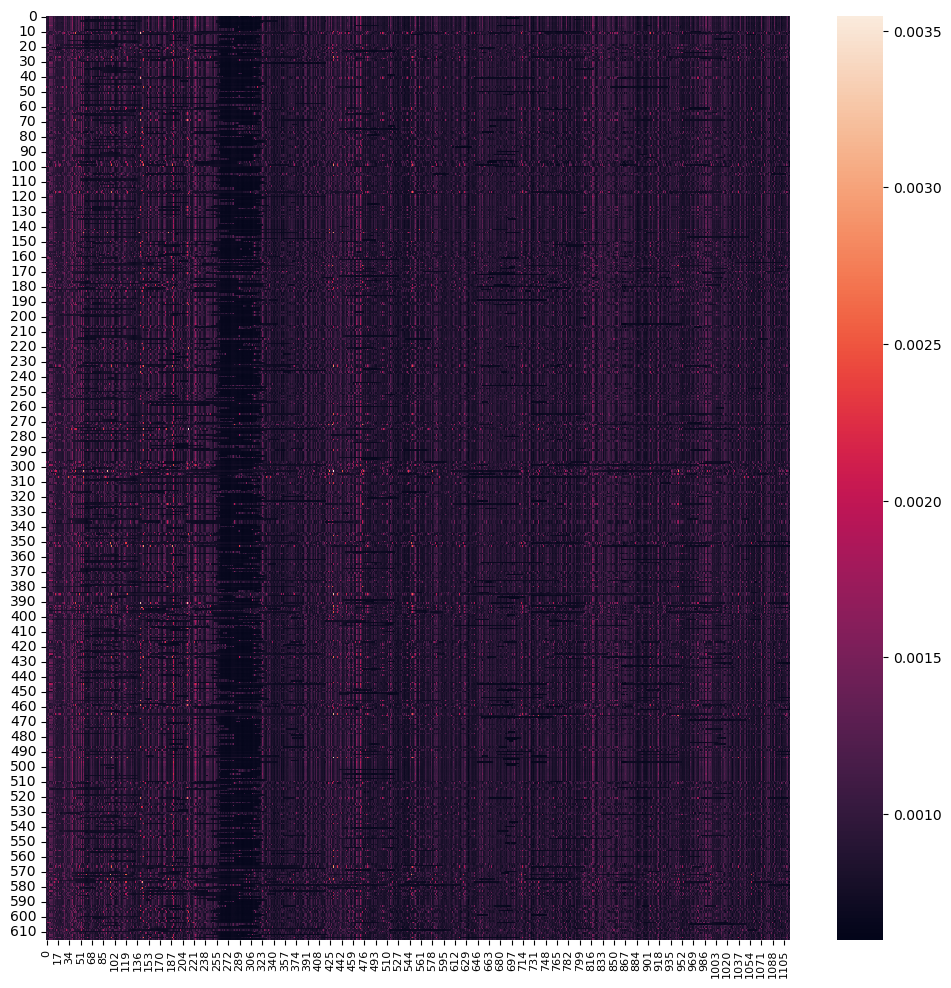

In [118]:
plt.figure(figsize=(12,12))
sns.heatmap(data=true_pred_attn_df)

(1115,)


<AxesSubplot:>

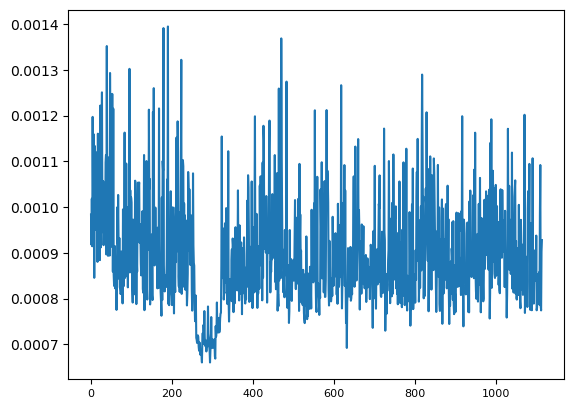

In [119]:
# plt.figure(figsize=(12,12))
print(true_pred_attn_df.mean(axis=0).shape)
sns.lineplot(data=true_pred_attn_df.mean(axis=0))

In [120]:
true_pred_attn_rank_df = true_pred_attn_df.rank("columns", ascending=False).astype(int)
true_pred_attn_rank_df

0     1     2     3     4     5     6     7     8     9     ...  1105  \
0     359   583   247   682    62   304    75    89   836    97  ...   910   
1     336   507   362   553    27   428    38    48   680    52  ...   877   
2     334   529   380   577    24   461    34    40   649    43  ...   755   
3     291   487   307   542    20   367    29    38   630    42  ...   745   
4     340   548   287   622    43   341    55    63   805    72  ...   893   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
611   297    36    37   648    44   371   257   266   625   128  ...    57   
612   289   450   346   501    23   403    34    45   618    51  ...   781   
613   349   553   299   629    43   361    55    64   790    72  ...   901   
614   302   300    96   128   472    37   552   412   705   321  ...   752   
615   341   540   314   600    36   375    51    58   744    64  ...   902   

     1106  1107  1108  1109  1110  1111  1112  1113  1114  
0     619   696  1028   287    73  1019   996   298   332  
1     644   668   995   308    76   967   965   323   350  
2     587   593   939   350    81   902   881   290   309  
3     593   597   945   283    85   890   864   305   328  
4     639   669  1008   301    75   997   971   322   349  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
611   913   864   203   248   634   644   188   830   624  
612   636   633   925   258    76   898   876   331   349  
613   627   676  1013   307    70   997   981   313   342  
614   147   687   742    28   159   172   404  1047  1070  
615   634   681  1009   302    72   990   979   321   344  

[616 rows x 1115 columns]

<AxesSubplot:>

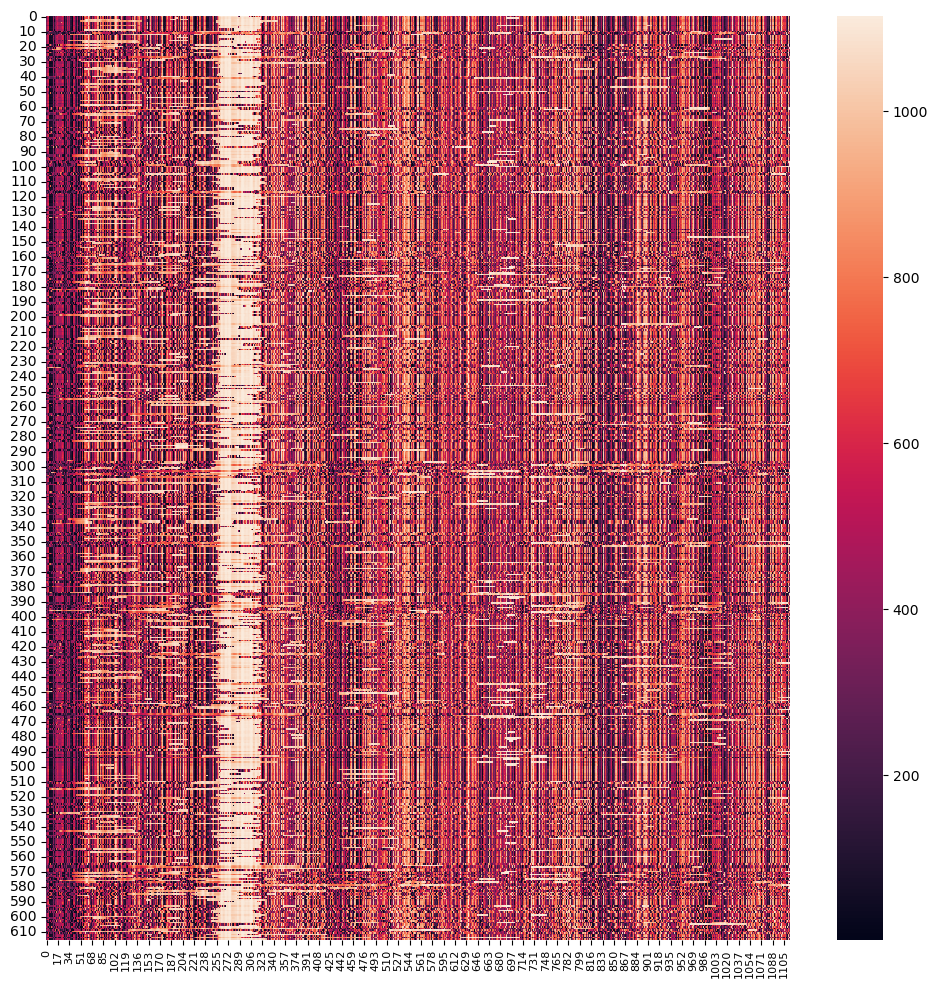

In [121]:
plt.figure(figsize=(12,12))
sns.heatmap(data=true_pred_attn_rank_df)

<AxesSubplot:>

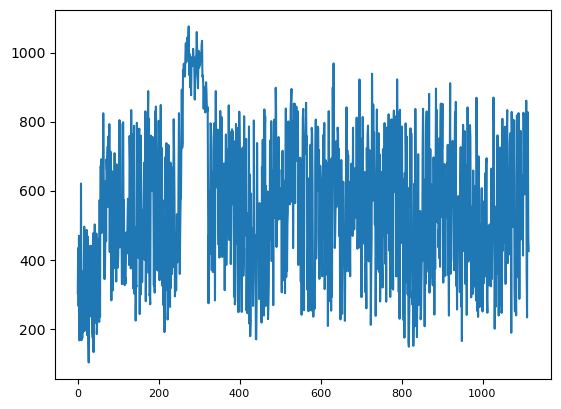

In [122]:
sns.lineplot(data=true_pred_attn_rank_df.mean(axis=0))

In [123]:
# retain only top 10 ranks
true_pred_attn_rank_df[true_pred_attn_rank_df > 10] = None
# drop all columns (positions) with all NaN i.e. this position is not in the top 10 for any sequence
# true_pred_attn_rank_df.dropna(axis=1, how="all", inplace=True)

# drop all columns (positions) with atleast 10% non-NaN values i.e. this position is not in the top 10 for 90% or more of the sequences
# argument 'thresh': Require that many non-NA values.
true_pred_attn_rank_df.dropna(axis=1, how="all", thresh=0.1*true_pred_attn_rank_df.shape[0], inplace=True)

In [125]:
true_pred_attn_rank_df

39   47    52   95  119  141  143   155  156   168  179  190  211  223  \
0    6.0  NaN  10.0  2.0  NaN  NaN  NaN   9.0  NaN   NaN  3.0  1.0  NaN  5.0   
1    8.0  9.0   NaN  2.0  NaN  NaN  NaN  10.0  NaN   NaN  3.0  1.0  NaN  5.0   
2    9.0  6.0   NaN  NaN  NaN  NaN  NaN   7.0  NaN   NaN  1.0  NaN  NaN  3.0   
3    8.0  5.0   NaN  NaN  NaN  NaN  NaN   7.0  NaN  10.0  2.0  1.0  NaN  4.0   
4    6.0  NaN  10.0  2.0  NaN  NaN  NaN   9.0  NaN   NaN  3.0  1.0  NaN  5.0   
..   ...  ...   ...  ...  ...  ...  ...   ...  ...   ...  ...  ...  ...  ...   
611  NaN  NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN   
612  9.0  8.0   NaN  2.0  NaN  NaN  NaN   NaN  NaN   NaN  3.0  1.0  NaN  5.0   
613  8.0  NaN  10.0  2.0  NaN  NaN  NaN   9.0  NaN   NaN  3.0  1.0  NaN  5.0   
614  NaN  NaN   NaN  NaN  5.0  NaN  NaN   NaN  6.0   NaN  NaN  NaN  NaN  NaN   
615  8.0  NaN  10.0  2.0  NaN  NaN  NaN   9.0  NaN   NaN  3.0  1.0  NaN  5.0   

     464  470  483  606  818  
0    8.0  4.0  7.0  NaN  NaN  
1    7.0  4.0  6.0  NaN  NaN  
2    5.0  2.0  4.0  NaN  8.0  
3    9.0  3.0  6.0  NaN  NaN  
4    8.0  4.0  7.0  NaN  NaN  
..   ...  ...  ...  ...  ...  
611  NaN  NaN  NaN  NaN  NaN  
612  7.0  4.0  6.0  NaN  NaN  
613  7.0  4.0  6.0  NaN  NaN  
614  NaN  NaN  NaN  NaN  NaN  
615  7.0  4.0  6.0  NaN  NaN  

[616 rows x 19 columns]

Int64Index([ 39,  47,  52,  95, 119, 141, 143, 155, 156, 168, 179, 190, 211,
            223, 464, 470, 483, 606, 818],
           dtype='int64')


<AxesSubplot:>

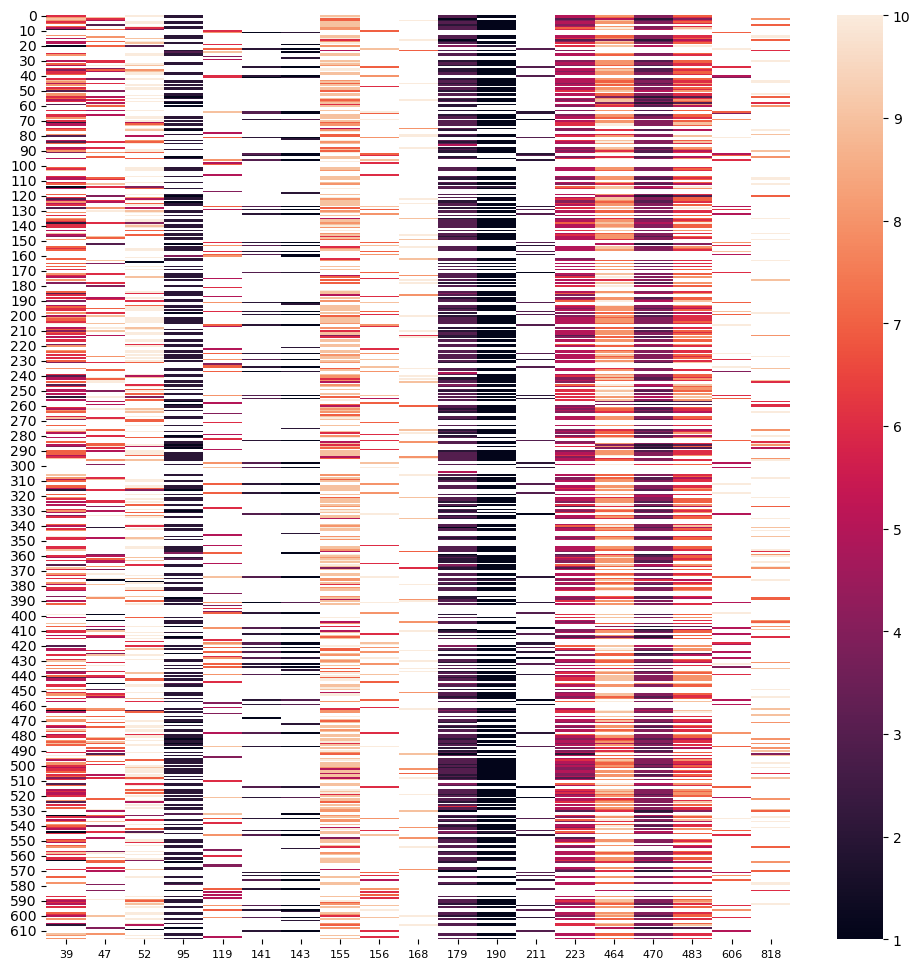

In [126]:
plt.figure(figsize=(12,12))
print(true_pred_attn_rank_df.columns.astype(int))
sns.heatmap(data=true_pred_attn_rank_df)

<AxesSubplot:>

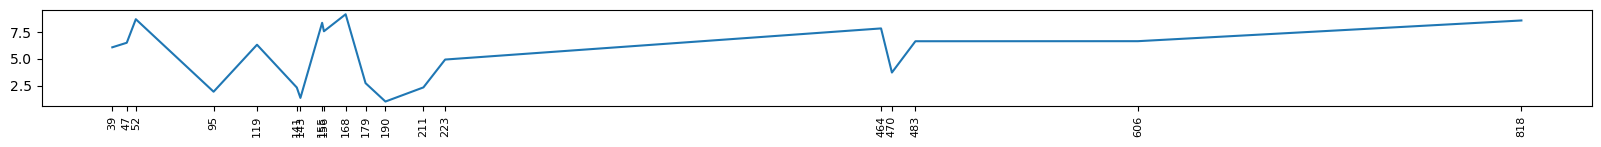

In [127]:
fig = plt.figure(figsize=(20,12))
plt.rcParams["figure.autolayout"] = True
plt.rcParams['xtick.labelsize'] = 8
plt.xticks(rotation=90)
plt.xticks(true_pred_attn_rank_df.columns.astype(int))
fig.subplots_adjust(bottom=0.8)
sns.lineplot(data=true_pred_attn_rank_df.mean(axis=0))

In [17]:
analyse_model(nlp_model, train_dataset_loader, coronavirus_dataset_loader, coronavirus_seq, coronavirus_label, seq_max_length=1115, viz_train=False, viz_test=False)

NameError: name 'train_dataset_loader' is not defined

max_seq_len_actual =  0


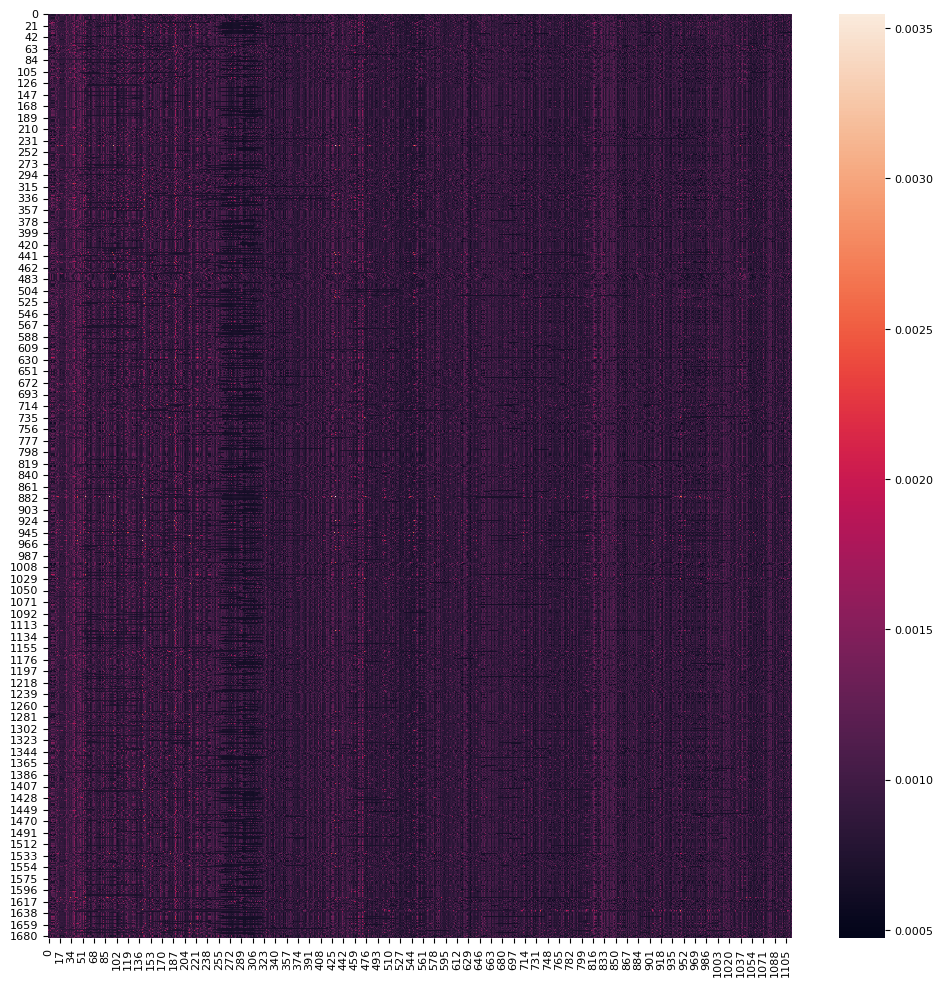

In [21]:
attn_df = analyze_attention_of_df(nlp_model, coronavirus_dataset_loader, seq_max_length=1115)

In [22]:
attn_df = pd.DataFrame(attn_df)
print(attn_df.shape)
x = attn_df.mean(axis=0)
attn_mean_df = pd.DataFrame({"attn_vals": x, "pos": range(1115)})
print(attn_mean_df.shape)
print(attn_mean_df.head())
attn_mean_df = attn_mean_df.dropna()
sorted_attn_df = attn_mean_df.sort_values(by="attn_vals", ascending=False).head(10)
print("Top 10 tokens + positions with highest attention values for the whole sequence")
print(sorted_attn_df.head(10))

(1683, 1115)
(1115, 2)
   attn_vals  pos
0   0.000949    0
1   0.000867    1
2   0.001028    2
3   0.000909    3
4   0.000972    4
Top 10 tokens + positions with highest attention values for the whole sequence
     attn_vals  pos
39    0.001303   39
190   0.001288  190
179   0.001261  179
52    0.001220   52
470   0.001211  470
27    0.001187   27
48    0.001172   48
223   0.001168  223
155   0.001157  155
95    0.001155   95


**Standard Deviation**

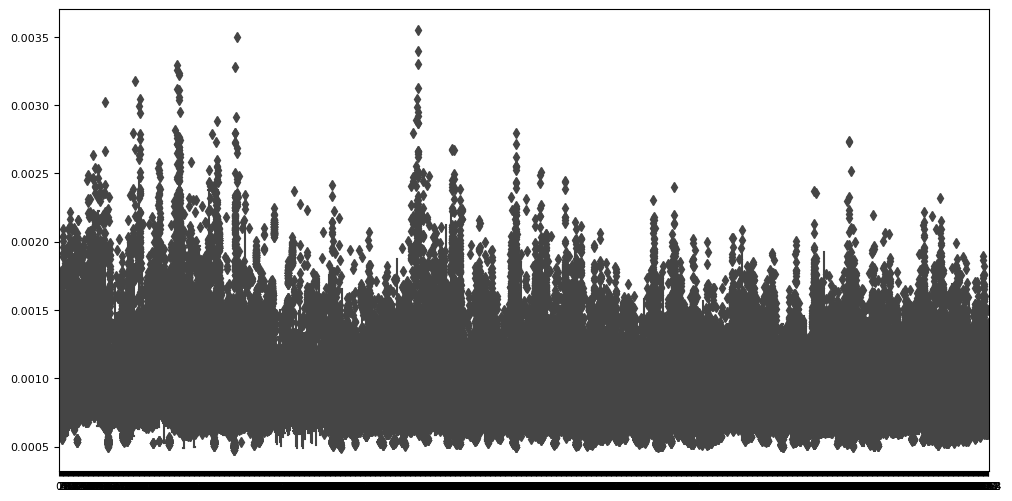

In [29]:
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.figure(figsize=(12,6))
std_vals = attn_df.std(axis=0)
sns.boxplot(attn_df)
#attn_std_df = pd.DataFrame({"attn_vals_std": std_vals, "pos": range(1115)})
#sns.scatterplot(data=attn_std_df, x="pos", y="attn_vals_std")
#sns.scatterplot(data=attn_df)
plt.show()

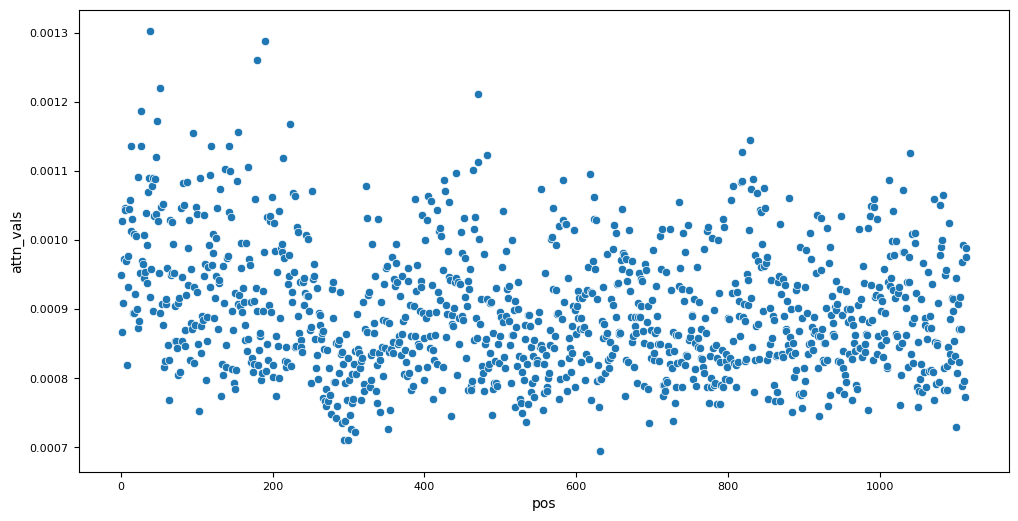

In [87]:
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.figure(figsize=(12,6))
sns.scatterplot(data=attn_mean_df, x="pos", y="attn_vals")
plt.show()

In [ ]:
from Bio import motifs
from Bio.Seq import Seq
from Bio.Alphabet import generic_protein

In [ ]:
instances = []
for s in uniref90_coronaviruses_humans_df["seq"]:
    if len(s) >= 900:
        instances.append(Seq(s[:900]))

In [ ]:
m = motifs.create(instances, alphabet=generic_protein)